# Kinect RGB-D Workflow: 
PLANT HEIGHT USING RGB-D IMAGES FROM KINECT 

In [21]:
# Set the notebook display method and libraries
# inline = embedded plots, notebook = interactive plots
%matplotlib notebook
import os
import argparse
import pandas as pd
import numpy as np
from plantcv import plantcv as pcv
from matplotlib import pyplot as plt

## Step 1: Load the csv file (depth- transformed file) that contains the distance per pixel (in mm): 

In [22]:
# INPUT VARIABLES
# Input image path/filename
#self.image = "C:/Users/jcard/OneDrive - University of Georgia/kinect_imaging/GH13_JC01/depth_csv/tray_1/T01_GH13_JC01_Feb-17-2023_0743_depth_values.csv"
  
        
csv_img = 'C:/Users/jcard/OneDrive - University of Georgia/kinect_imaging/GH13_JC01/depth_csv/harvest_reference/depth_csv/T01_GH13_JC01_Feb-23-2023_0729_depth_values.csv'
    
## Set debug to the global parameter
pcv.params.debug = "plot"

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 20
pcv.params.text_thickness = 10

## Step 2: Maximum Height Reference value 
Use the distance between an empty raft and a camera sensor to obtain plant height calculated as difference between minimum height and reference height. 

Here, we need to implement a function that takes the image of the empty raft and extracts the mode (or mean) value that will be used as a reference. So instead of assigning a value for ref_height the function will automatically define it. 

In [54]:
ref_height = 1270


## Step 3: Uploading and cropping csv image to match color cropped image. 

<IPython.core.display.Javascript object>


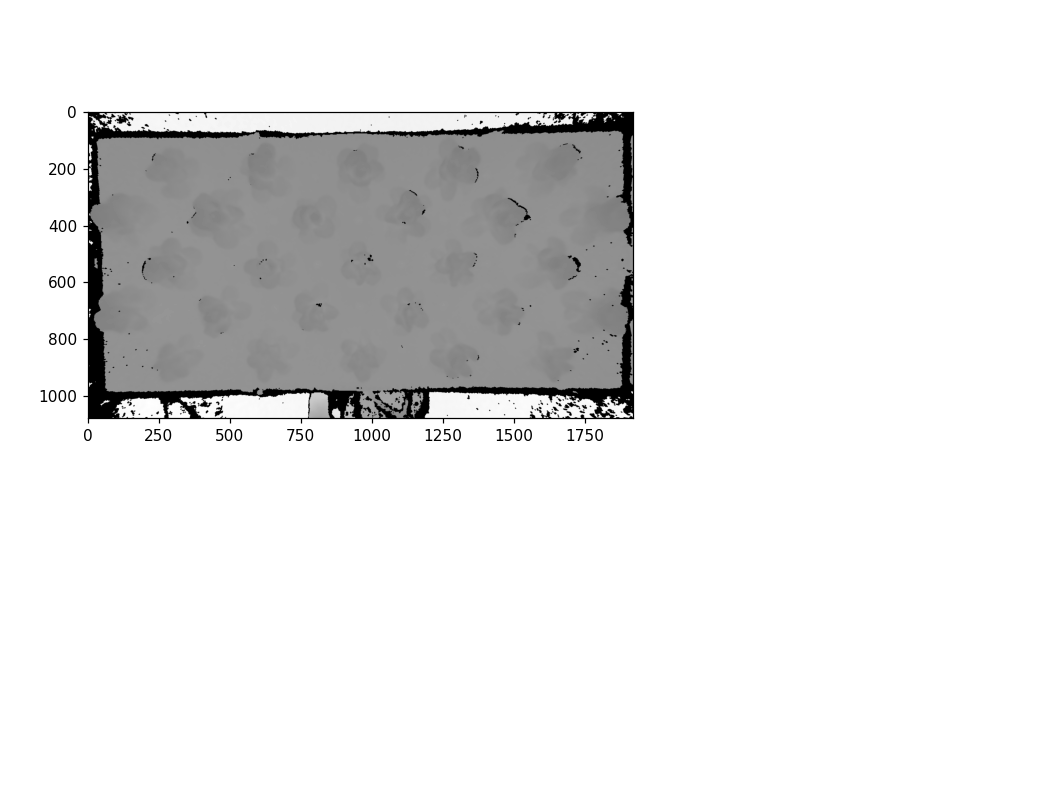

In [24]:
# Inputs:
# filename = Image file to be read in 
# mode = How to read in the image; either 'native' (default), 
# 'rgb', 'gray', 'csv', or 'envi

img, path, filename = pcv.readimage(filename= csv_img,mode = "csv")

<IPython.core.display.Javascript object>


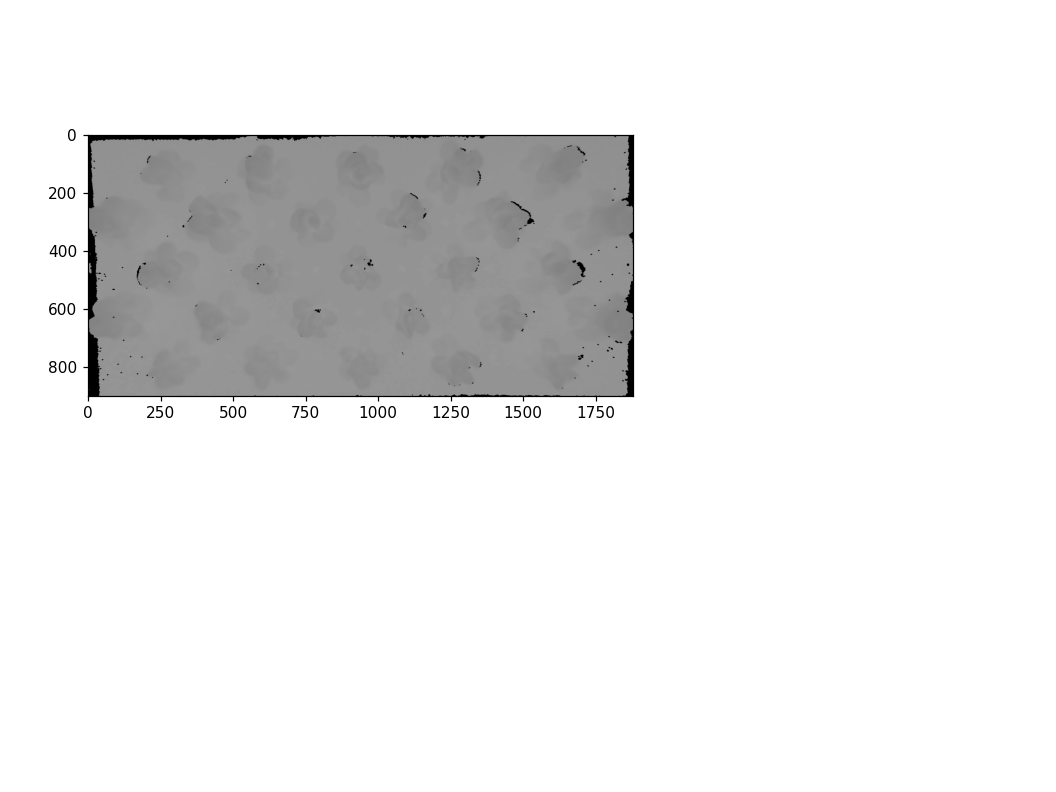

In [26]:
cropped_csv = img[75:975, 22:1900] 
pcv.plot_image(cropped_csv)

<IPython.core.display.Javascript object>


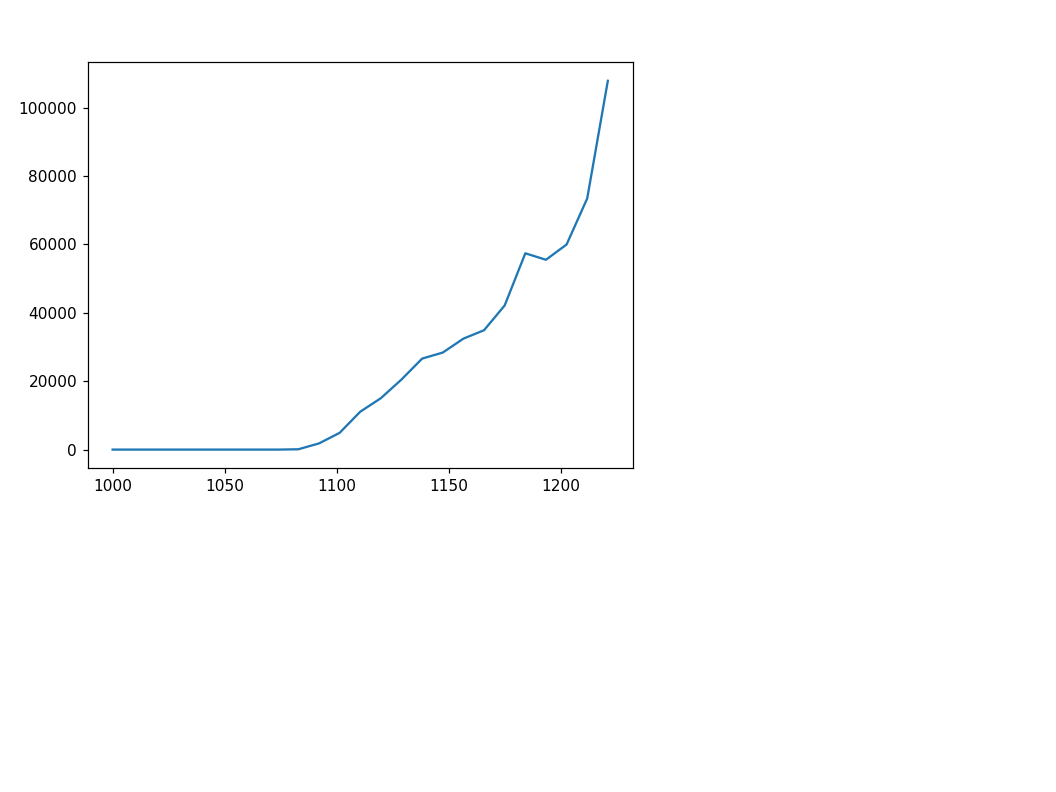

In [53]:
histogram_depth, bin_edges = np.histogram(cropped_csv, bins=25,range=(1000,1230))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram_depth)



<IPython.core.display.Javascript object>


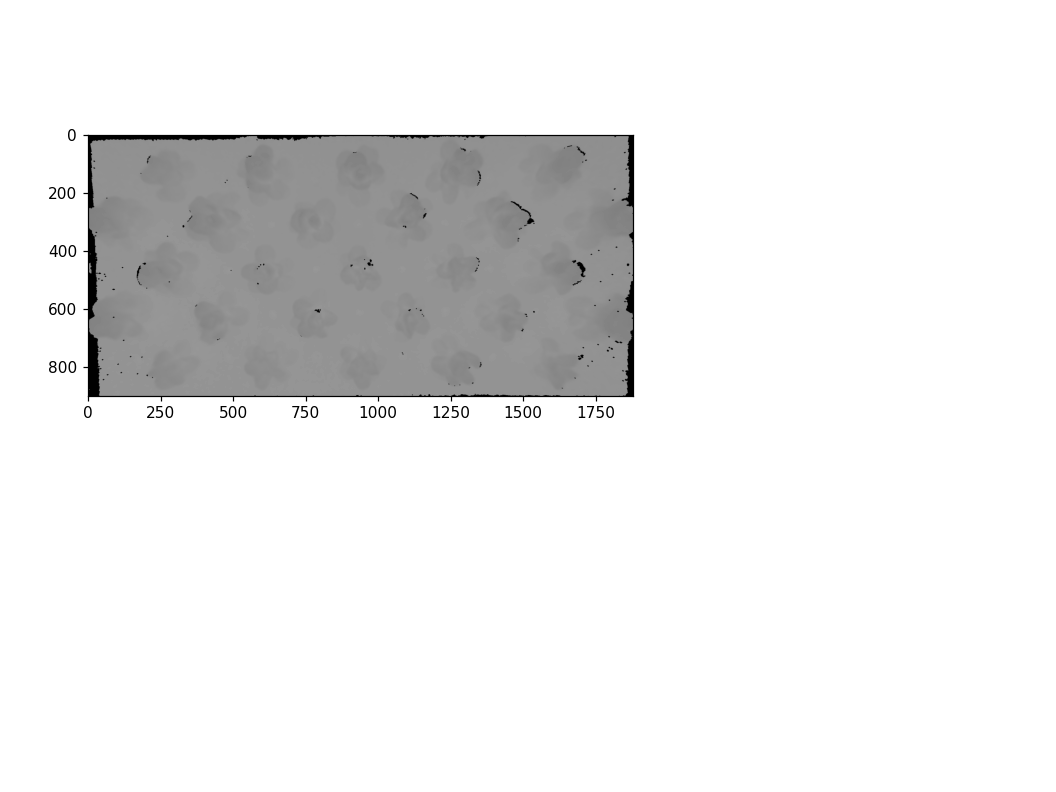

In [28]:
scaled_distance_img = pcv.transform.rescale(gray_img=cropped_csv)

<IPython.core.display.Javascript object>


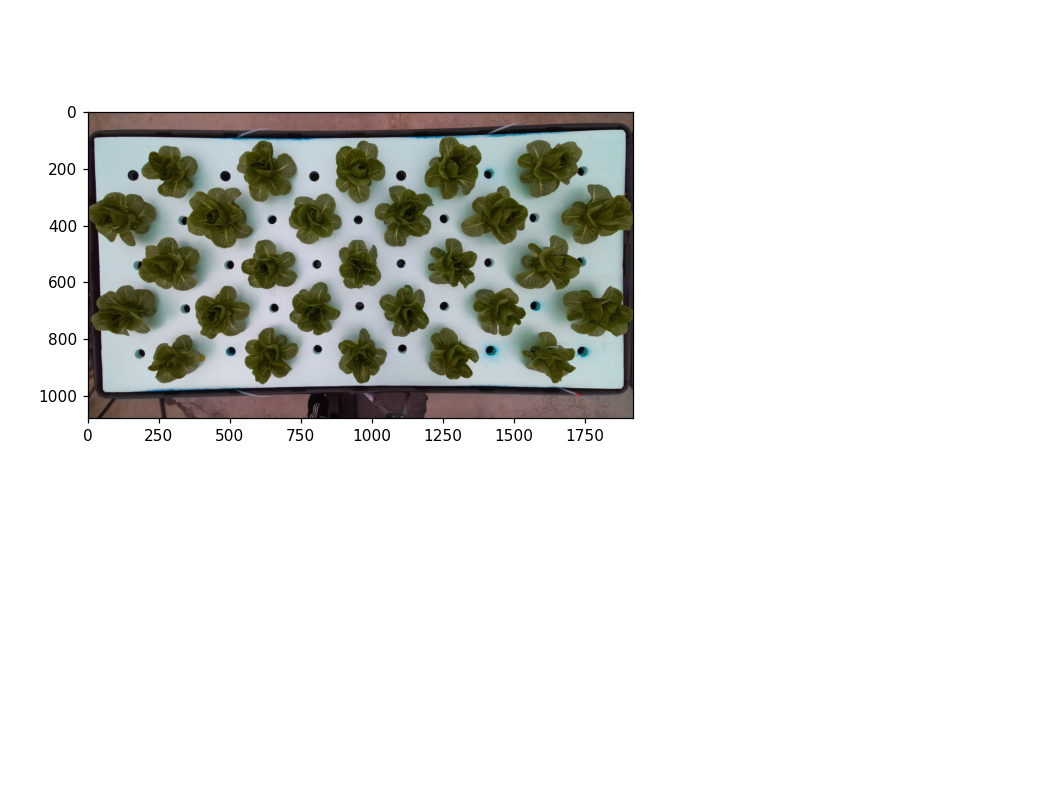

In [29]:
path_color = "C:/Users/jcard/OneDrive - University of Georgia/kinect_imaging/GH13_JC01/depth_csv/harvest_reference/rgb/T01_GH13_JC01_Feb-23-2023_0729_rgb.jpg"
color_img,path_color,filename_color =  pcv.readimage(filename=path_color, mode="rgb")

<IPython.core.display.Javascript object>


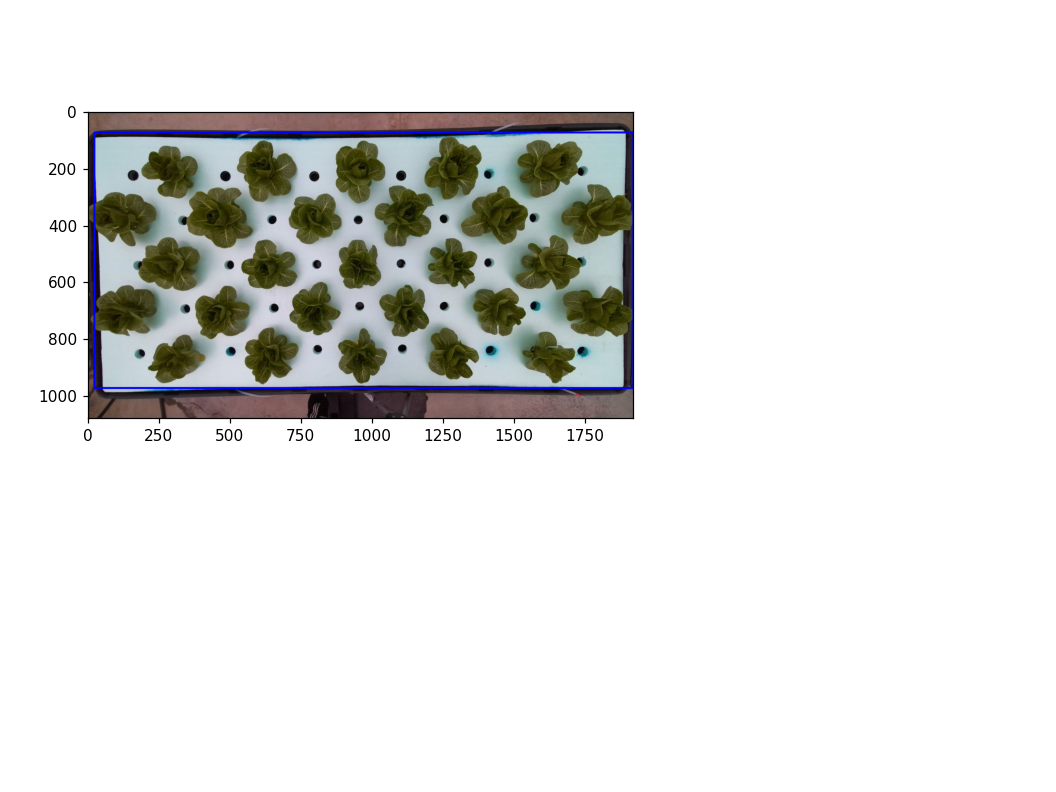

In [30]:
cropped_color = pcv.crop(img=color_img, x=22, y=75, h=900, w=1900) # 75:975, 22:1875

<IPython.core.display.Javascript object>


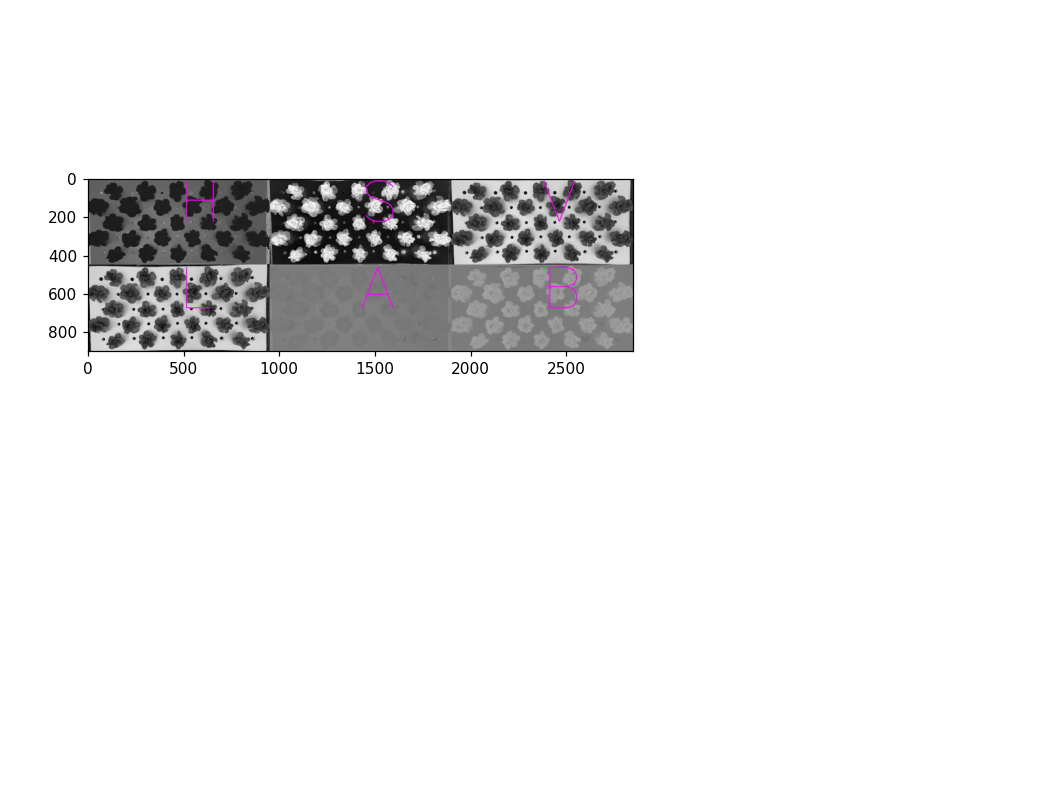

In [31]:

# Visualize colorspaces
## The visualization tool converts the color image into HSV and LAB colorspaces and displays the 
## grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to 
## select a channel that maximizes the difference between the plant and the background pixels.
colorspace_img = pcv.visualize.colorspaces(rgb_img= cropped_color,original_img=False)

<IPython.core.display.Javascript object>


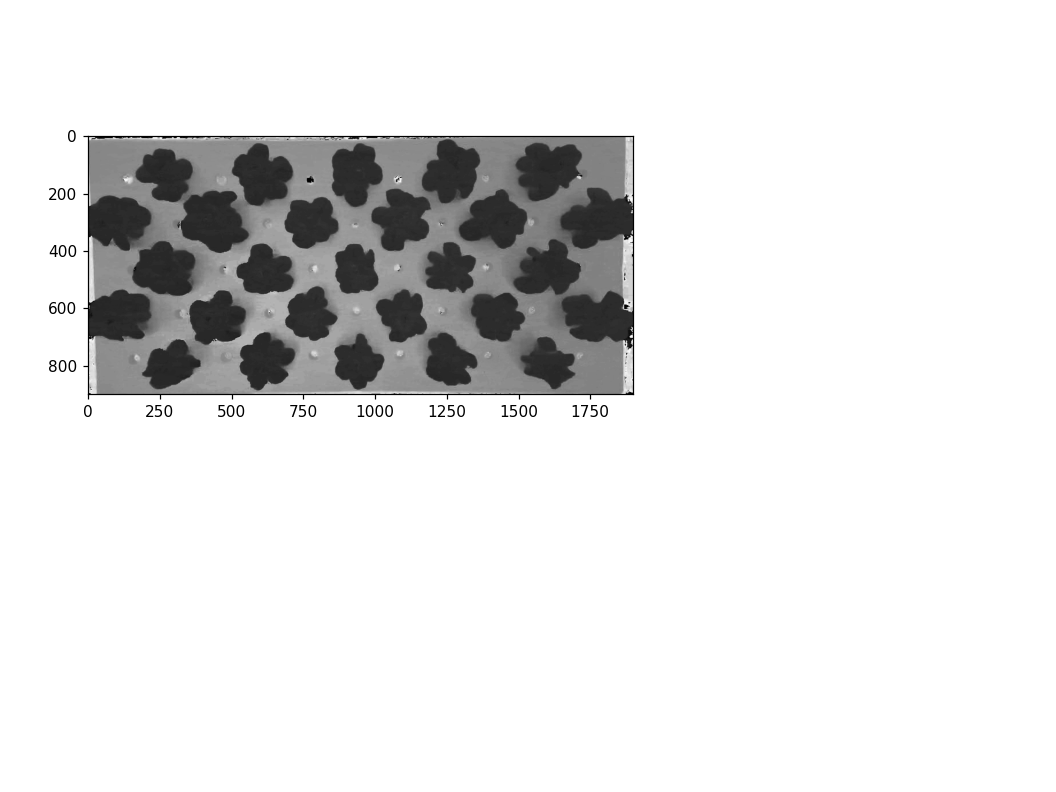

In [32]:
# To improve colorspaces visualization, cut the image in such a way that just light blue background is visible. 
# (X and Y are starting X,Y coordinate respectively)
# h = y_axis total lenght , w = x_axis total lenght

hsv_h = pcv.rgb2gray_hsv(rgb_img=cropped_color, channel='h')

<IPython.core.display.Javascript object>


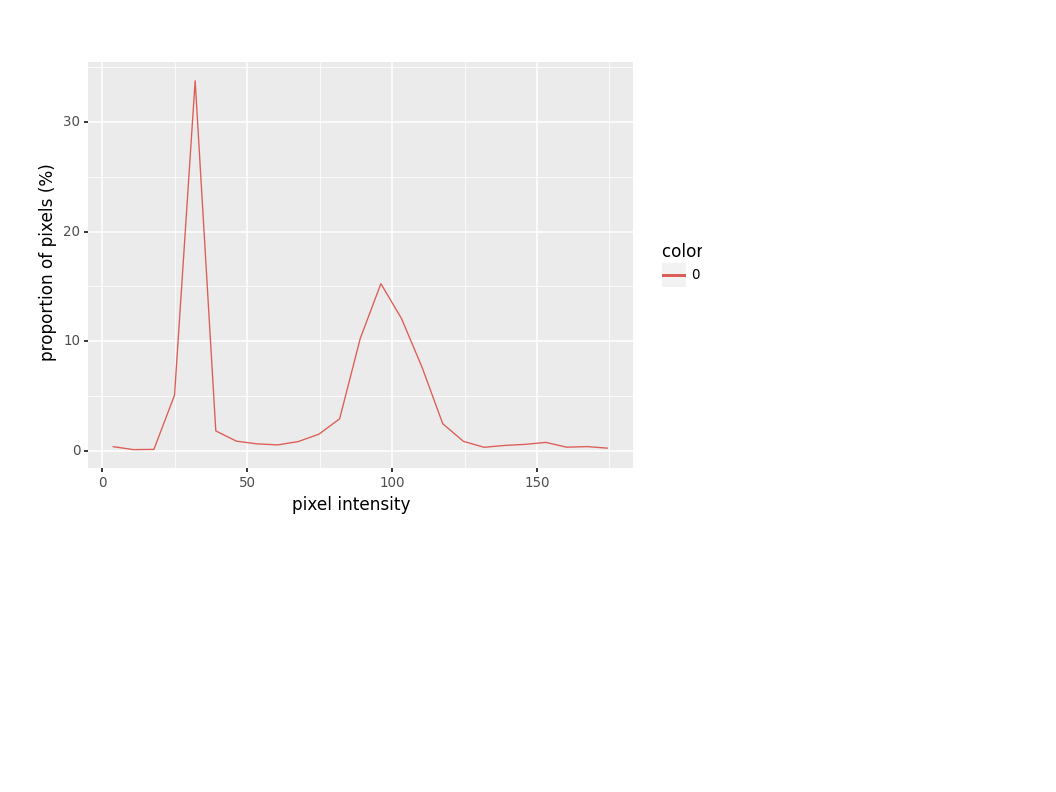

In [33]:
# Visualize the distribution of grayscale values
## A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the 
## selection of a threshold value.

## For this image, the large peak between 100-140 are from the brighter background pixels. 
## The smaller peak between 80-90 are the darker plant pixels.

# Inputs:
#   img         = a color or grayscale image
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img= hsv_h, bins=25)

<IPython.core.display.Javascript object>


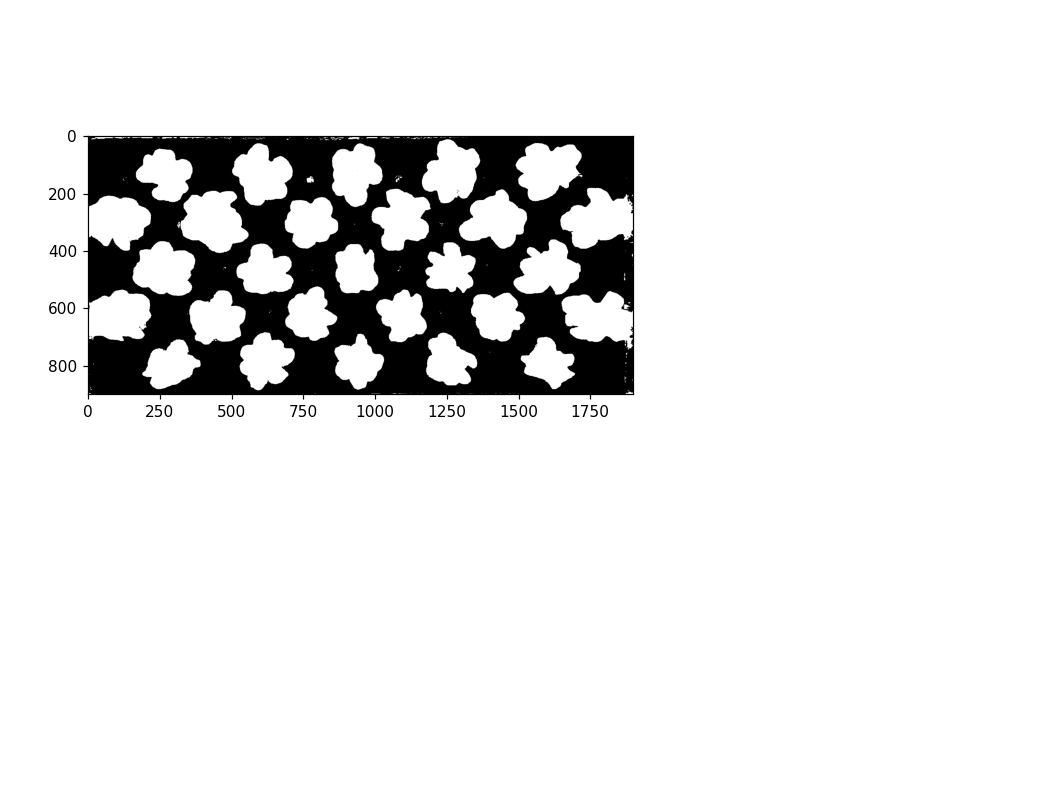

In [34]:
# Threshold the grayscale image
## Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and 
## background (black) pixels. Using the histogram above, a threshold point between 90-110 will segment the plant 
## and background peaks. Because the plants are the darker pixels in this image, use object_type="dark" to do an inverse threshold.
thresh = pcv.threshold.binary(gray_img=hsv_h, threshold=50, max_value=255, object_type='dark')

<IPython.core.display.Javascript object>


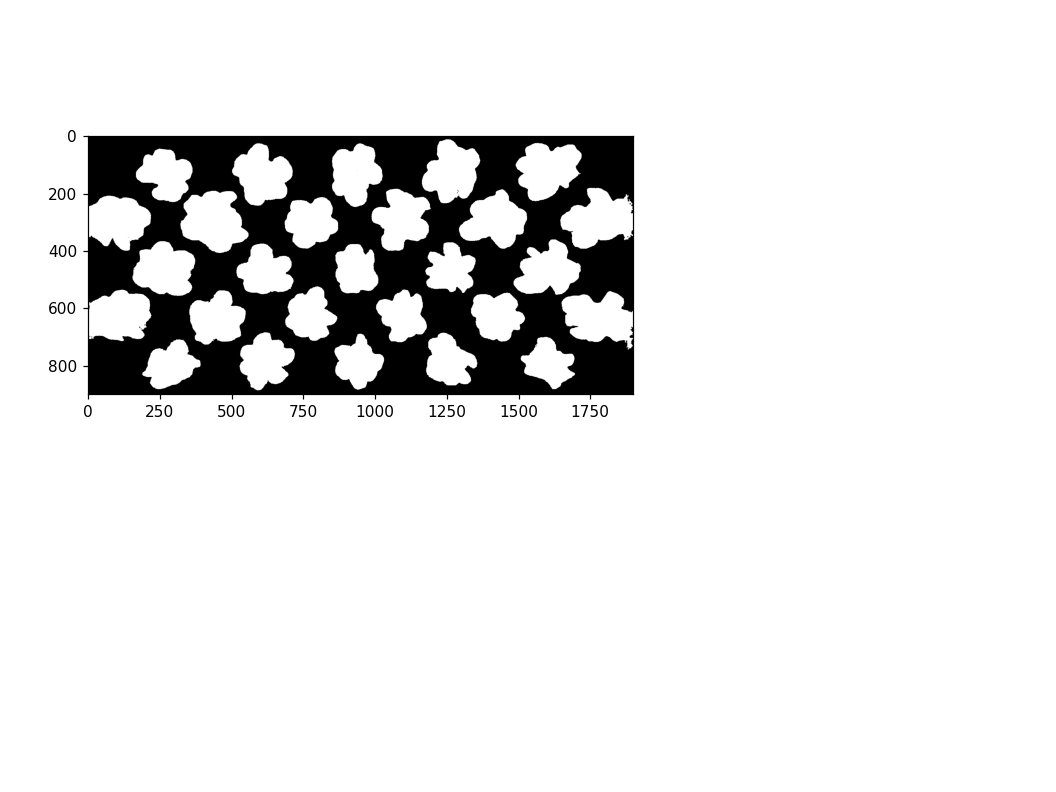

In [35]:
fill = pcv.fill(thresh,size = 1500)

<IPython.core.display.Javascript object>


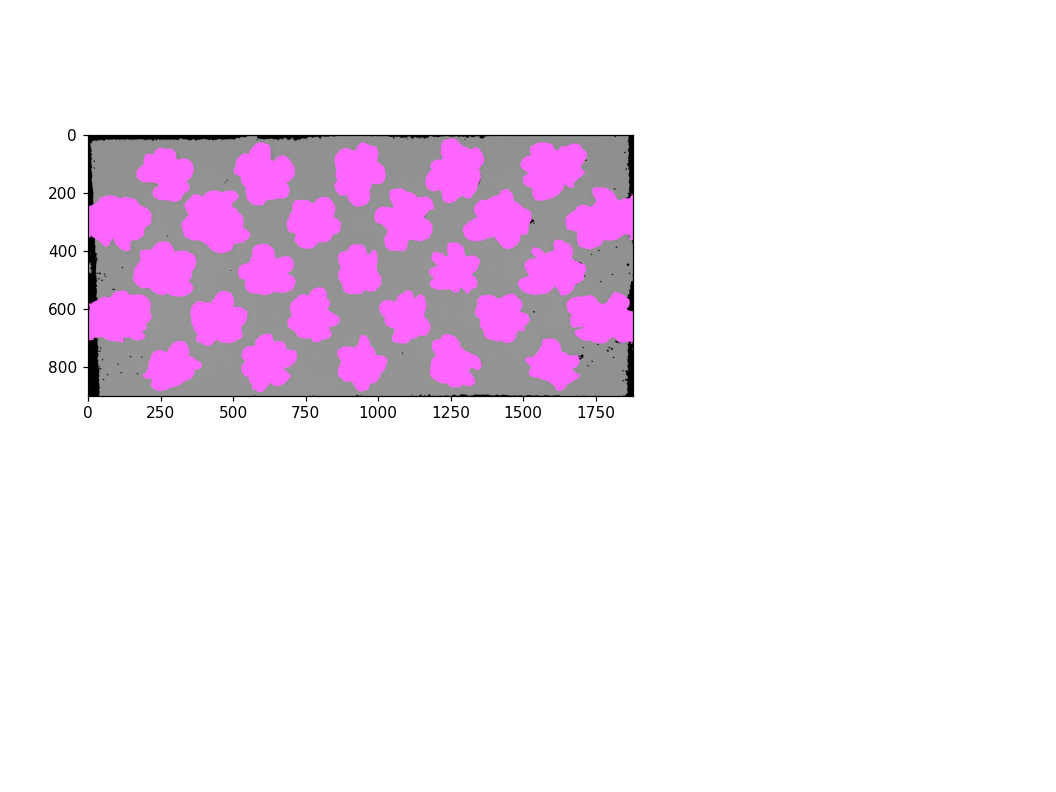

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [36]:
obj, obj_hierarchy = pcv.find_objects(img = scaled_distance_img, mask=fill)
pcv.plot_image(obj)

In [40]:
rois, roi_hierarchy = pcv.roi.multi(img=scaled_distance_img, coord=(111,118), radius=50, 
                                    spacing=(165, 161), nrows=5, ncols=11)

<IPython.core.display.Javascript object>


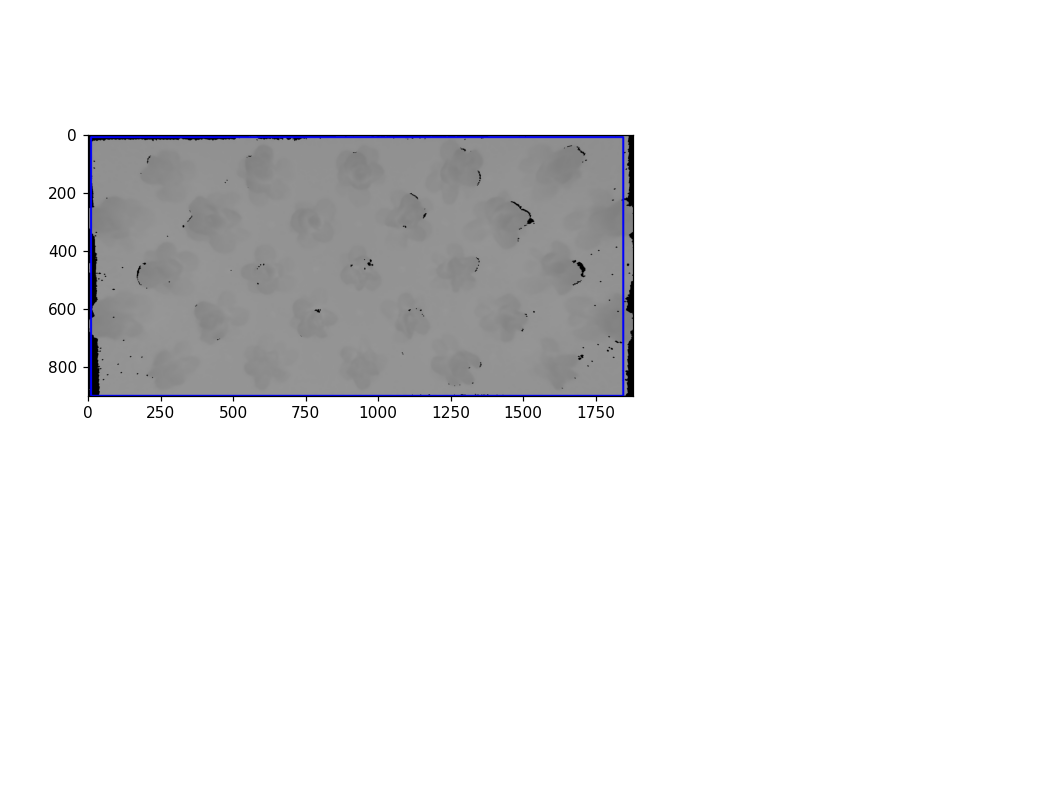

In [38]:
roi_rec, roi_hierarchy_rec = pcv.roi.rectangle(scaled_distance_img, x=10, y=10, h=890, w=1835)

In [39]:
roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(scaled_distance_img, 'partial', roi_rec, roi_hierarchy_rec,
                                                                           obj, obj_hierarchy)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - hierarchy is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'hierarchy'


In [41]:
# Create a unique ID for each plant
## Create a sequence of values to label each plant within the image based on the ROI IDs.

# Inputs:
#   start = beginning value for range
#   stop  = ending value for range (exclusive)
plant_ids = range(0, len(rois))

<IPython.core.display.Javascript object>


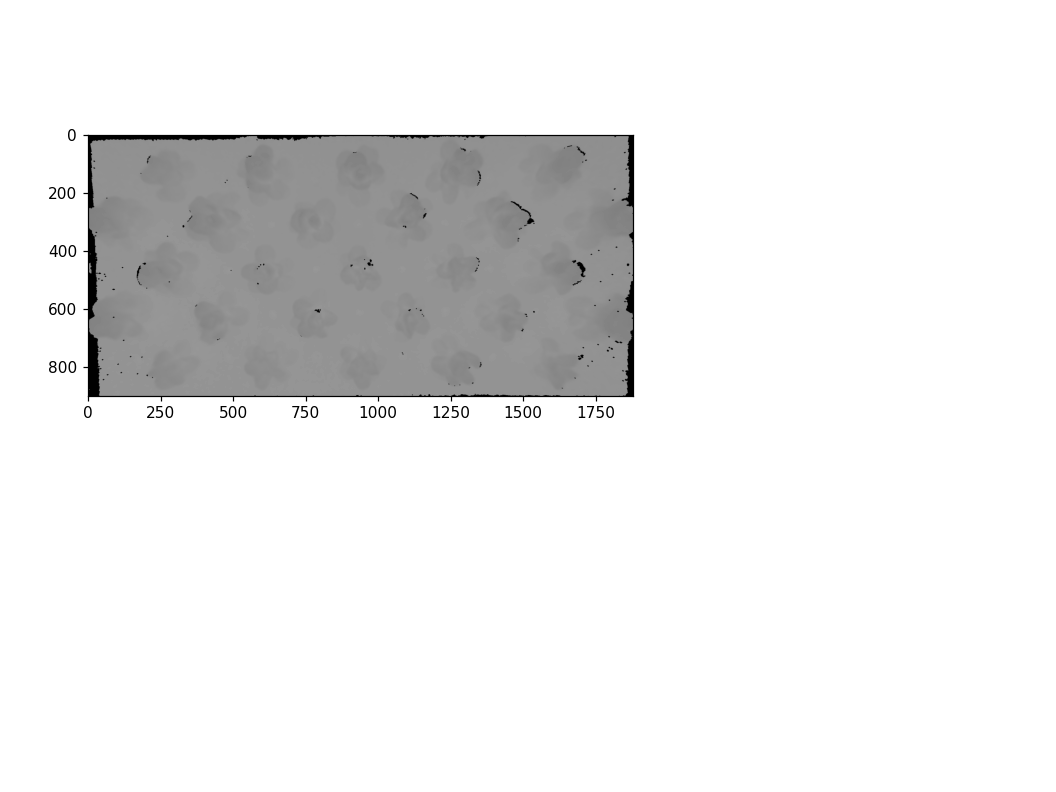

In [42]:
img_copy = np.copy(scaled_distance_img)

# Set debug to None (plotting all of the images would be very verbose output)
pcv.params.debug = None

for i in range(0, len(rois)):
    # The ith ROI, ROI hierarchy, and plant ID
    roi = rois[i]
    hierarchy = roi_hierarchy[i]
    plant_id = plant_ids[i]
    # Subset objects that overlap the ROI
    # Inputs:
    #   img            = input image
    #   roi_contour    = a single ROI contour
    #   roi_hierarchy  = a single ROI hierarchy
    #   object_contour = all objects detected in a binary mask
    #   obj_hierarchy  = all object hierarchies
    #   roi_type       = "partial" (default) keeps contours that overlap
    #                    or are contained in the ROI. "cutto" cuts off
    #                    contours that fall outside the ROI. "largest"
    #                    only keeps the largest object within the ROI
    plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=scaled_distance_img, 
                                                                  roi_contour=roi, 
                                                                  roi_hierarchy=hierarchy, 
                                                                  object_contour=obj, 
                                                                  obj_hierarchy=obj_hierarchy, 
                                                                  roi_type="partial")

    # If the plant area is zero then no plant was detected for the ROI
    # and no measurements can be done
    if area > 0:
        # Combine contours together for each plant
        # Inputs:
        #   img       = input image
        #   contours  = contours that will be consolidated into a single object
        #   hierarchy = the relationship between contours
        plant_obj, plant_mask = pcv.object_composition(img=scaled_distance_img, 
                                                       contours=plant_contours, 
                                                       hierarchy=plant_hierarchy)       
        # Analyze the shape of each plant
        # Inputs:
        #   img   = input image
        #   obj   = composed object contours
        #   mask  = binary mask that contours were derived from
        #   label = a label for the group of measurements (default = "default")
        thermal = pcv.analyze_thermal_values(cropped_csv, plant_mask, histplot=True, label=f"plant{plant_id}")
        #img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                      #mask=plant_mask, label=f"plant{plant_id}")
        

pcv.plot_image(img_copy)

In [43]:
# Save the results
## During analysis, measurements are stored in the background in the outputs recorder.

## This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 
## 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 
## 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using anayze_object.

## If other functions, for example color analysis, are desired, these should be included in the for loop.

## Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format
#                                   or "csv" tabular format
pcv.outputs.save_results(filename="results_depth.csv", outformat="csv")

In [44]:
pcv.outputs.observations

{'plant1': {'max_temp': {'trait': 'maximum temperature',
   'method': 'plantcv.plantcv.analyze_thermal_values',
   'scale': 'degrees',
   'datatype': "<class 'float'>",
   'value': 1254.0,
   'label': 'degrees'},
  'min_temp': {'trait': 'minimum temperature',
   'method': 'plantcv.plantcv.analyze_thermal_values',
   'scale': 'degrees',
   'datatype': "<class 'float'>",
   'value': 0.0,
   'label': 'degrees'},
  'mean_temp': {'trait': 'mean temperature',
   'method': 'plantcv.plantcv.analyze_thermal_values',
   'scale': 'degrees',
   'datatype': "<class 'float'>",
   'value': 1191.6118052384709,
   'label': 'degrees'},
  'median_temp': {'trait': 'median temperature',
   'method': 'plantcv.plantcv.analyze_thermal_values',
   'scale': 'degrees',
   'datatype': "<class 'float'>",
   'value': 1199.0,
   'label': 'degrees'},
  'thermal_frequencies': {'trait': 'thermal frequencies',
   'method': 'plantcv.plantcv.analyze_thermal_values',
   'scale': 'frequency',
   'datatype': "<class 'list'>"

In [46]:
plant_data = pcv.outputs.observations

data_parameters = {}
for key in plant_data['plant1'].keys():
  data_parameters['plant_'+ key] = []
  for plant in plant_data.keys():
     data_parameters['plant_'+ key].append(plant_data[plant][key]['value'])

plant_observation = list(plant_data.keys())

data_set = pd.DataFrame(data_parameters)
data_set.insert(0, 'plant_id', plant_observation) 
height_mm = data_set['plant_max_temp'] - data_set['plant_min_temp'] 
data_set.insert(1, 'height_mm', height_mm)
data_set.info()
data_set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   plant_id                   46 non-null     object 
 1   height_mm                  46 non-null     float64
 2   plant_max_temp             46 non-null     float64
 3   plant_min_temp             46 non-null     float64
 4   plant_mean_temp            46 non-null     float64
 5   plant_median_temp          46 non-null     float64
 6   plant_thermal_frequencies  46 non-null     object 
dtypes: float64(5), object(2)
memory usage: 2.6+ KB


,plant_id,height_mm,plant_max_temp,plant_min_temp,plant_mean_temp,plant_median_temp,plant_thermal_frequencies
0,plant1,1254.0,1254.0,0.0,1191.611805,1199.0,"[0.39018720684072894, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,plant3,1262.0,1262.0,0.0,1192.611981,1206.0,"[0.11155809472296406, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,plant5,1252.0,1252.0,0.0,1184.084507,1187.0,"[0.0743245754208629, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,plant7,1260.0,1260.0,0.0,1171.705042,1183.0,"[0.768172822112643, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,plant9,1257.0,1257.0,0.0,1168.909779,1186.0,"[0.8034880099657428, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,plant10,1257.0,1257.0,0.0,1168.909779,1186.0,"[0.8034880099657428, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,plant11,1272.0,1272.0,0.0,1162.537434,1195.0,"[2.2503562787922977, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,plant12,1254.0,1254.0,0.0,1191.611805,1199.0,"[0.39018720684072894, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,plant13,1273.0,1273.0,0.0,1197.464690,1208.0,"[0.30237092717664676, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,plant14,1262.0,1262.0,0.0,1192.611981,1206.0,"[0.11155809472296406, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [55]:
data_parameters = {}
for key in plant_data['plant1'].keys():
  data_parameters['plant_'+ key] = []
  for plant in plant_data.keys():
     data_parameters['plant_'+ key].append(plant_data[plant][key]['value'])

plant_observation = list(plant_data.keys())

data_set2 = pd.DataFrame(data_parameters)
data_set2.insert(0, 'plant_id', plant_observation) 
height_mm = ref_height- data_set2['plant_min_temp'] 
data_set2.insert(1, 'height_mm', height_mm)
data_set2.info()
data_set2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   plant_id                   46 non-null     object 
 1   height_mm                  46 non-null     float64
 2   plant_max_temp             46 non-null     float64
 3   plant_min_temp             46 non-null     float64
 4   plant_mean_temp            46 non-null     float64
 5   plant_median_temp          46 non-null     float64
 6   plant_thermal_frequencies  46 non-null     object 
dtypes: float64(5), object(2)
memory usage: 2.6+ KB


,plant_id,height_mm,plant_max_temp,plant_min_temp,plant_mean_temp,plant_median_temp,plant_thermal_frequencies
0,plant1,1270.0,1254.0,0.0,1191.611805,1199.0,"[0.39018720684072894, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,plant3,1270.0,1262.0,0.0,1192.611981,1206.0,"[0.11155809472296406, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,plant5,1270.0,1252.0,0.0,1184.084507,1187.0,"[0.0743245754208629, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,plant7,1270.0,1260.0,0.0,1171.705042,1183.0,"[0.768172822112643, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,plant9,1270.0,1257.0,0.0,1168.909779,1186.0,"[0.8034880099657428, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,plant10,1270.0,1257.0,0.0,1168.909779,1186.0,"[0.8034880099657428, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,plant11,1270.0,1272.0,0.0,1162.537434,1195.0,"[2.2503562787922977, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,plant12,1270.0,1254.0,0.0,1191.611805,1199.0,"[0.39018720684072894, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,plant13,1270.0,1273.0,0.0,1197.464690,1208.0,"[0.30237092717664676, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,plant14,1270.0,1262.0,0.0,1192.611981,1206.0,"[0.11155809472296406, 0.0, 0.0, 0.0, 0.0, 0.0,..."
